# Identifying High-Response Customer Segments

- **Objective**: Identify customer groups most likely to respond positively to marketing promotions.
- **Business Impact**: Helps target promotions efficiently, saving cost and improving ROI.

## 1. Data Preparation
- Load the Dataset
- Inspect the data; column types, missing values, preview
- Handle missing values
- Clean & normalize values; standardize text fields, date conversion, duplicates
- Feature engineering; is_discounted, used_promo, loyalty_score, high_spender etc
- Encode categorical variables; OHE, label encoding(ordinal)
- Scale numerical features

### 1.1 Load & Inspect Data

In [37]:
# Import libraries
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set(style="whitegrid")
%matplotlib inline

In [4]:
# Load the dataset
df = pd.read_csv("data/shopping_behavior_updated.csv")
# Preview the dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (3900, 18)


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [5]:
# Data summary
print("Dataset summary:")
df.info()

Dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used        

In [7]:
# Summary statistics
print("Summary statistics:")
df.describe(include='all')

Summary statistics:


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
count,3900.000000,3900.000000,3900,3900,3900,3900.000000,3900,3900,3900,3900,3900.000000,3900,3900,3900,3900,3900.000000,3900,3900
unique,NaN,NaN,2,25,4,NaN,50,4,25,4,NaN,2,6,2,2,NaN,6,7
top,NaN,NaN,Male,Blouse,Clothing,NaN,Montana,M,Olive,Spring,NaN,No,Free Shipping,No,No,NaN,PayPal,Every 3 Months
freq,NaN,NaN,2652,171,1737,NaN,96,1755,177,999,NaN,2847,675,2223,2223,NaN,677,584
mean,1950.500000,44.068462,NaN,NaN,NaN,59.764359,NaN,NaN,NaN,NaN,3.749949,NaN,NaN,NaN,NaN,25.351538,NaN,NaN
std,1125.977353,15.207589,NaN,NaN,NaN,23.685392,NaN,NaN,NaN,NaN,0.716223,NaN,NaN,NaN,NaN,14.447125,NaN,NaN
min,1.000000,18.000000,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,2.500000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
25%,975.750000,31.000000,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,NaN,3.100000,NaN,NaN,NaN,NaN,13.000000,NaN,NaN
50%,1950.500000,44.000000,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,3.700000,NaN,NaN,NaN,NaN,25.000000,NaN,NaN
75%,2925.250000,57.000000,NaN,NaN,NaN,81.000000,NaN,NaN,NaN,NaN,4.400000,NaN,NaN,NaN,NaN,38.000000,NaN,NaN


### 1.2 Clean & Normalize Columns

In [8]:
# Standardize text columns and replace spaces with underscores
def standardize_text_columns(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    return df

df = standardize_text_columns(df)

# Number of duplicate rows
print("Duplicates present:", df.duplicated().sum())

Duplicates present: 0


In [9]:
# Sanity check for normalization
print("Sanity check for normalization:")
print(df.columns.to_list())

Sanity check for normalization:
['customer_id', 'age', 'gender', 'item_purchased', 'category', 'purchase_amount_(usd)', 'location', 'size', 'color', 'season', 'review_rating', 'subscription_status', 'shipping_type', 'discount_applied', 'promo_code_used', 'previous_purchases', 'payment_method', 'frequency_of_purchases']


### 1.3 Feature Engineering

In this step we'll engineer some features that will help us distinguish who’s likely to respond to promotions. We’ll add four new columns:

- `freq_per_year` – Converts frequency_of_purchases to numeric representation of purchases per year.
- Convert all boolean columns into integers using map function
- `loyalty_score` – combines Previous Purchases and Frequency of Purchases into one metric (normalized scores- MinMaxScaler)
- `High_Spender` – flags customers whose average Purchase Amount is above the 75th percentile

In [10]:
# Convert boolean columns to integers
bool_map = {'yes': 1, 'no': 0}
df['subscription_status'] = df['subscription_status'].astype(str).str.lower().map(bool_map)
df['discount_applied'] = df['discount_applied'].astype(str).str.lower().map(bool_map)
df['promo_code_used'] = df['promo_code_used'].astype(str).str.lower().map(bool_map)

df['frequency_of_purchases'] = (df['frequency_of_purchases'].astype(str).str.lower().str.strip())

# Map frequency_of_purchases → true numeric “purchases per year”
freq_map = {
    'annually': 1,
    'every 3 months': 4,
    'quarterly': 4,
    'monthly': 12,
    'bi-weekly': 26,
    'fortnightly': 26,
    'weekly': 52
}
df['freq_per_year'] = df['frequency_of_purchases'].map(freq_map)


# 3) Compute a loyalty_score on numeric bases:
#    - normalize previous_purchases and freq_per_year to [0,1]
#    - sum them so score ∈ [0,2]
scaler = MinMaxScaler()
df[['prev_norm','freq_norm']] = scaler.fit_transform(df[['previous_purchases','freq_per_year']])
df['loyalty_score'] = (df['prev_norm'] + df['freq_norm']).round(2)

# 4) Flag high spenders: those above the 75th percentile of purchase_amount_usd
threshold = df['purchase_amount_(usd)'].quantile(0.75)
df['high_spender'] = (df['purchase_amount_(usd)'] > threshold).astype(int)

# 5) Clean up intermediate columns
df.drop(columns=['prev_norm','freq_norm'], inplace=True)

In [11]:
# Sanity check for feature engineering
print("Sanity check for feature engineering:")
df.sample(5)

Sanity check for feature engineering:


,customer_id,age,gender,item_purchased,category,purchase_amount_(usd),location,size,color,season,...,subscription_status,shipping_type,discount_applied,promo_code_used,previous_purchases,payment_method,frequency_of_purchases,freq_per_year,loyalty_score,high_spender
75,76,64,Male,Scarf,Accessories,85,Utah,M,Blue,Summer,...,1,Free Shipping,1,1,21,Credit Card,annually,1,0.41,1
2011,2012,57,Male,Sandals,Footwear,94,West Virginia,M,Beige,Spring,...,0,Express,0,0,4,Bank Transfer,monthly,12,0.28,1
1329,1330,70,Male,Gloves,Accessories,63,Texas,M,Indigo,Fall,...,0,Express,1,1,50,PayPal,every 3 months,4,1.06,0
3438,3439,26,Female,Shirt,Clothing,71,Kentucky,M,Violet,Fall,...,0,Store Pickup,0,0,33,Credit Card,monthly,12,0.87,0
1205,1206,52,Male,Handbag,Accessories,99,California,M,Olive,Spring,...,0,Standard,1,1,38,Bank Transfer,fortnightly,26,1.25,1


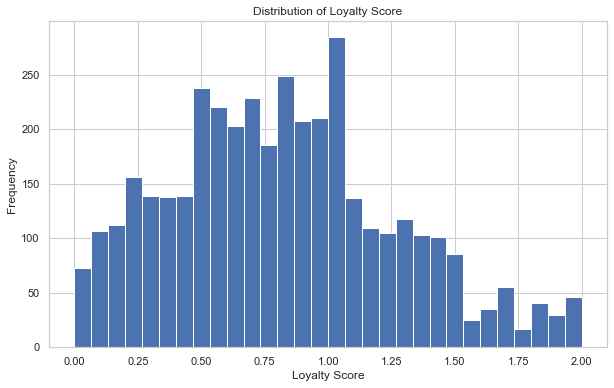

In [12]:
# Explore the loyalty score
plt.figure(figsize=(10, 6))
plt.hist(df['loyalty_score'], bins=30)
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')
plt.title('Distribution of Loyalty Score');

A larger proportion of the customers lies between 0 and 1 score. Let's explore the lowest score of 0.00 to check whether it's valid

In [13]:
# Inspect the loyalty score zero
df[df['loyalty_score'] == 0]

,customer_id,age,gender,item_purchased,category,purchase_amount_(usd),location,size,color,season,...,subscription_status,shipping_type,discount_applied,promo_code_used,previous_purchases,payment_method,frequency_of_purchases,freq_per_year,loyalty_score,high_spender
1228,1229,55,Male,Jacket,Outerwear,55,Indiana,S,Yellow,Winter,...,0,Express,1,1,1,Cash,annually,1,0.0,0
1610,1611,20,Male,Socks,Clothing,31,Tennessee,L,Purple,Spring,...,0,2-Day Shipping,1,1,1,PayPal,annually,1,0.0,0
1690,1691,40,Male,Coat,Outerwear,30,Nevada,M,Black,Summer,...,0,Free Shipping,0,0,1,Cash,annually,1,0.0,0
1772,1773,58,Male,Shoes,Footwear,34,Hawaii,M,Gold,Summer,...,0,2-Day Shipping,0,0,1,Bank Transfer,annually,1,0.0,0
1842,1843,61,Male,Handbag,Accessories,78,Alabama,M,Black,Summer,...,0,Express,0,0,1,Debit Card,annually,1,0.0,0
2174,2175,42,Male,Backpack,Accessories,49,Colorado,S,Olive,Spring,...,0,Store Pickup,0,0,1,Cash,annually,1,0.0,0
2471,2472,30,Male,Sandals,Footwear,83,Oklahoma,M,Gray,Spring,...,0,Store Pickup,0,0,1,Cash,annually,1,0.0,1
2573,2574,54,Male,T-shirt,Clothing,90,New Mexico,M,Red,Summer,...,0,Store Pickup,0,0,1,Bank Transfer,annually,1,0.0,1
3728,3729,62,Female,Jacket,Outerwear,31,Vermont,L,Red,Winter,...,0,Standard,0,0,1,Debit Card,annually,1,0.0,0


Customers with a loyalty score of 0.00 share some characteristics, they all have an annual frequency of purchase and have a single previous purchase which justifies the score.

In [10]:
# # Filter numeric and categorical columns
# numeric_columns = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
# categorical_columns = [col for col in df.columns if pd.api.types.is_object_dtype(df[col])]

# # Combine numeric and categorical columns
# columns_to_plot = numeric_columns + categorical_columns

# # Set the number of rows and columns for the grid
# n_cols = 7  # Increase the number of columns for a landscape view
# n_rows = -(-len(columns_to_plot) // n_cols)  # Calculate rows to fit all plots

# # Create subplots
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
# axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# # Plot each column
# for i, column in enumerate(columns_to_plot):
#     ax = axes[i]
#     if column in numeric_columns:
#         sns.histplot(df[column], kde=True, bins=30, ax=ax)
#         ax.set_title(f'Distribution of {column} (Numerical)')
#     elif column in categorical_columns:
#         sns.countplot(x=df[column], ax=ax, order=df[column].value_counts().index)
#         ax.set_title(f'Distribution of {column} (Categorical)')
#     ax.set_xlabel(column)
#     ax.set_ylabel('Frequency')

# # Remove unused subplots
# for j in range(len(columns_to_plot), len(axes)):
#     fig.delaxes(axes[j])  # Delete any unused axes

# plt.tight_layout()
# plt.show()

### 1.4 Encode & Scale

In this section we'll be converting our categorical varibles into integers and scale the numerical variables to share a common scale in modeling. Let's start with checking unique values in the categorical columns to avoid exploded features which might affect our models

**- Check for Cardinality of Categorical Columns**

In [11]:
# Check cardinality of categorical columns
categorical_cols = [
    'gender','item_purchased','category','location',
    'size','color','season','shipping_type','payment_method'
]

for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"{col}: {n_unique} unique values")

gender: 2 unique values
item_purchased: 25 unique values
category: 4 unique values
location: 50 unique values
size: 4 unique values
color: 25 unique values
season: 4 unique values
shipping_type: 6 unique values
payment_method: 6 unique values


From the cardinality check, here's what stands out:

- `location`: 50 unique values – high
- `item_purchased`: 25 unique values – moderate
- `color`: 25 unique values – moderate

We'll be reducing this counts to avoid bloated one-hot encoding

In [14]:
# Helper function to reduce categories
def reduce_categories(series, threshold=None):
    """
    Groups rare categories in a Series into 'Other'.
    threshold: proportion (e.g. 0.02 = 2%) below which to group.
    """
    freq = series.value_counts(normalize=True)
    keep = freq[freq > threshold].index
    return series.apply(lambda x: x if x in keep else 'Other')


df['location'] = reduce_categories(df['location'], threshold=0.02)
df['item_purchased'] = reduce_categories(df['item_purchased'], threshold=0.04)
df['color'] = reduce_categories(df['color'], threshold=0.04)

In [15]:
print(df[['location', 'item_purchased', 'color']].nunique())

location          23
item_purchased    16
color             11
dtype: int64


**- Encoding Categorical Variables**

In [17]:
categorical_cols = ['gender', 'item_purchased', 'category', 'location', 'size', 
                    'color', 'season', 'shipping_type', 'payment_method']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(df_encoded.shape)
df_encoded.head()

(3900, 79)


,customer_id,age,purchase_amount_(usd),review_rating,subscription_status,discount_applied,promo_code_used,previous_purchases,frequency_of_purchases,freq_per_year,...,shipping_type_Express,shipping_type_Free Shipping,shipping_type_Next Day Air,shipping_type_Standard,shipping_type_Store Pickup,payment_method_Cash,payment_method_Credit Card,payment_method_Debit Card,payment_method_PayPal,payment_method_Venmo
0,1,55,53,3.1,1,1,1,14,fortnightly,26,...,1,0,0,0,0,0,0,0,0,1
1,2,19,64,3.1,1,1,1,2,fortnightly,26,...,1,0,0,0,0,1,0,0,0,0
2,3,50,73,3.1,1,1,1,23,weekly,52,...,0,1,0,0,0,0,1,0,0,0
3,4,21,90,3.5,1,1,1,49,weekly,52,...,0,0,1,0,0,0,0,0,1,0
4,5,45,49,2.7,1,1,1,31,annually,1,...,0,1,0,0,0,0,0,0,1,0


This marks the end of our data preparation step, our data is model-ready. Next, we'll be moving to th second step; modeling step.

## 2. Modeling

**- Create a Binary Target**

We'll use a composite target derived from `promo_code_used` and `discount_applied` to represent any positive reaction to a promotion

In [18]:
# Define composite target
df_encoded['responded_to_promo'] = ((df_encoded['promo_code_used'] == 1) | (df_encoded['discount_applied'] == 1)).astype(int)

# Inspect class balance
print(df_encoded['responded_to_promo'].value_counts(normalize=True))

0    0.57
1    0.43
Name: responded_to_promo, dtype: float64


In [16]:
# correlation of all numeric features with the target
corrs = df_encoded.corr()['responded_to_promo'].abs().sort_values(ascending=False)
print(corrs.head(15))

responded_to_promo            1.000000
discount_applied              1.000000
promo_code_used               1.000000
customer_id                   0.857496
subscription_status           0.700202
gender_Male                   0.595823
item_purchased_Socks          0.042873
location_Indiana              0.040551
item_purchased_Blouse         0.039283
item_purchased_Other          0.025791
item_purchased_Sandals        0.025589
item_purchased_Coat           0.025435
previous_purchases            0.023537
shipping_type_Next Day Air    0.022764
size_S                        0.021937
Name: responded_to_promo, dtype: float64


**- Train/Test Split & Scaling**

In [23]:
# Drop leakage & ID columns from df_encoded
leakage_and_id = ['promo_code_used','discount_applied','customer_id', 'frequency_of_purchases'] # frequency_of_purchases is not needed anymore
df_model = df_encoded.drop(columns=leakage_and_id + ['responded_to_promo'], errors='ignore')

# Capture feature columns for later use
feature_cols = list(df_model.columns) 

# save to disk
with open("models/feature_columns.json","w") as f:
    json.dump(feature_cols, f)


# Define X and y
X = df_model.copy()
y = df_encoded['responded_to_promo']

# Train‑test split (stratified)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scale numeric features
num_cols = ['age', 'previous_purchases', 'freq_per_year', 'loyalty_score']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

### 2.1. Logistic Regression - Baseline

In [ ]:
# Instantiate & train
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predict & evaluate
y_pred_lr = lr.predict(X_test) # Discrete class predictions → Array of 0s and 1s
y_proba_lr = lr.predict_proba(X_test)[:,1] # [:,1]extracts the probability of the positive class (Class 1) → Array of probabilities

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       445
           1       0.83      0.75      0.79       335

    accuracy                           0.83       780
   macro avg       0.83      0.82      0.82       780
weighted avg       0.83      0.83      0.82       780

Logistic Regression ROC AUC: 0.9205634747610263


_Classification Report Insights_

`Precision` (82% for class 0, 83% for class 1)
- This tells us how many of the predicted positives were actually correct.
- Our LogisticRegression model has balanced precision across both classes—this is great for minimizing false positives.

`Recall` (88% for class 0, 75% for class 1)

- This shows how many actual positives were correctly identified.
- Our model has higher recall for class 0 but lower recall for class 1, meaning it might be missing some positives (false negatives).

`F1-score` (85% for class 0, 79% for class 1)
 - Since F1-score balances precision and recall, this suggests class 1 predictions could improve slightly in recall.

`Accuracy`: 83%
- A solid result overall—our model is correctly classifying 83% of instances.

`ROC AUC Score`
- 0.92 is excellent—this means the model has strong separation ability between classes.

### 2.2. Random Forest

In [26]:
# Instantiate & train
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       445
           1       0.82      0.70      0.76       335

    accuracy                           0.81       780
   macro avg       0.81      0.79      0.80       780
weighted avg       0.81      0.81      0.80       780

Random Forest ROC AUC: 0.9131913466375985


- `Logistic Regression` has slightly higher recall for class 1, meaning it catches more positive cases.
- `Random Forest` has high precision but lower recall, which suggests it may be more conservative in predicting class 1.
- `Logistic Regression` edges out `Random Forest` by a small margin (0.9206 vs. 0.9132 AUC).
- It’s also more interpretable: you can directly inspect coefficients to see which features drive response.
- We'll use Logistic Regression as our primary model, and keep Random Forest as a backup or for further comparison after tuning.

Next, we'll tune our classification models to try and improve performance.

### 2.3. Hyperparameter Tuning via GridSearchCV

- **Logistic Regression: tune regularization strength C**

In [33]:
# Set up parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],       # inverse regularization strength
    'penalty': ['l1','l2'],            # L1 or L2 regularization
    'solver': ['liblinear']            # supports L1
}

# 5‑fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid_lr,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR CV AUC:", grid_lr.best_score_)

Best LR params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best LR CV AUC: 0.919899371286116


Tuning logistic regression slightly reduced AUC score

- Best C=0.1 → Indicates strong regularization helped improve performance.
- Best penalty='l1' → Suggests sparse feature selection may be beneficial.
- Best ROC AUC Score = 0.92 → Confirms strong model performance

- **Random Forest: tune `n_estimators`, `max_depth`, `min_samples_leaf`**

In [35]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [1, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid_rf,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF CV AUC:", grid_rf.best_score_)

Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best RF CV AUC: 0.9257110322436463


### 2.4. Cross-Validation Stability

When we tuned our models with GridSearchCV, we optimized hyperparameters based on the average AUC across folds, but a single 'best score' doesn't tell us how much that performance might vary if the data were split differently. 

Let's go ahead and perform cross-validation to check if our model achieves consistent AUC across multiple folds.

In [39]:
best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

lr_scores = cross_val_score(best_lr, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_scores = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print("LR 5‑fold AUC:", lr_scores, "mean:", lr_scores.mean())
print("RF 5‑fold AUC:", rf_scores, "mean:", rf_scores.mean())

LR 5‑fold AUC: [0.92234404 0.91393803 0.92753752 0.91403738 0.92163988] mean: 0.919899371286116
RF 5‑fold AUC: [0.92901015 0.91673654 0.92867998 0.9271166  0.92701189] mean: 0.9257110322436463


Cross-validation stability test confirms that both models generalize well. Random Forest (AUC: 0.9257) showed slightly higher consistency across folds compared to Logistic Regression (AUC: 0.9199). RF had less variance, suggesting better overall stability, while LR still maintained strong performance.

<!-- ### Model Selection

| Model               | 5‑Fold CV AUC | Notes                                         |
| ------------------- | ------------- | --------------------------------------------- |
| Logistic Regression |        0.9199 | Very interpretable, nearly as good            |
| Random Forest       |        0.9257 | Slightly better AUC, captures non‑linearities | -->

The model performs consistently across different folds, the stable performance suggests the model will generalize better to truly unseen data (future customers).

> **Confidence in Business Decisions**

When presenting to stakeholders, you can say:

“Our model’s AUC ranged only ±0.005 across 5 folds—so we expect similarly high performance in production.”

- We'll use the `Random Forest` as you primary scoring model, and retain the Logistic Regression as an interpretable check.

Best model report:

```
Mean AUC: 0.9257 (matches our GridSearchCV best score)

Range: 0.917–0.929 → a spread of ~0.012

Std. Dev.: small (≈0.005), indicating high stability

That tells us the model’s performance is consistently high, and we can trust its AUC estimate.
```
>Side note:
In practice, always report both the mean and the standard deviation of CV scores.
If the std. dev. is large (>0.02–0.03), consider gathering more data, simplifying the model, or adding regularization.
Use these stability metrics when discussing model readiness with stakeholders.

### 2.5. Feature Importance Analysis

In [40]:
# Extract feature importance
feature_importances = best_rf.feature_importances_

# Create DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top features
print(importance_df.head(10))

                  Feature  Importance
3     subscription_status    0.288284
8             gender_Male    0.219750
1   purchase_amount_(usd)    0.044085
6           loyalty_score    0.043221
0                     age    0.042250
4      previous_purchases    0.040685
2           review_rating    0.038543
5           freq_per_year    0.018065
49                 size_M    0.009169
46         location_Other    0.008268


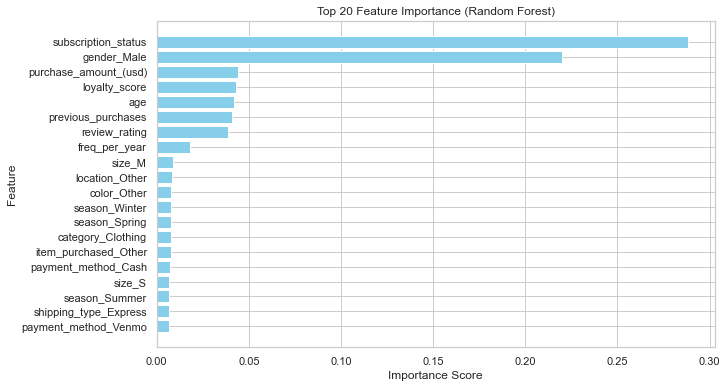

In [51]:
# Select top 20 most important features
top_n = 20
importance_df_top = importance_df.head(top_n)

# Plot only top features
plt.figure(figsize=(10,6))
plt.barh(importance_df_top['Feature'], importance_df_top['Importance'], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

### 2.6. Threshold Optimization

Moving on to Threshold Selection, our goal is to pick the probability cutoff 𝑡 at which we call a customer “likely responder.” 

This choice balances:
- **Precision** (of those we target, how many actually respond)
- **Recall** (of all responders, how many we catch)
- **Business trade‑off** (cost of sending a promo vs. uplift gained)


For each candidate threshold 𝑡:

1. Compute predicted labels:

    $𝑦^𝑖(𝑡)$ = $ 1 if 𝑝^𝑖 ≥ 𝑡 0 otherwise ​$
 
2. Calculate

    - F1‑score: harmonic mean of precision & recall — balances false positives vs. false negatives.

    - Youden’s J: 𝐽 = sensitivity + specificity − 1. Maximizing 𝐽 finds the point on the ROC curve farthest from random guessing.

In [52]:
# get LR probabilities on validation fold
y_proba = best_lr.predict_proba(X_test)[:,1]

# Evaluate F1 at various thresholds
thresholds = np.linspace(0.1, 0.9, 81)
f1s = [f1_score(y_test, y_proba >= t) for t in thresholds]
best_idx = np.argmax(f1s)
best_thresh, best_f1 = thresholds[best_idx], f1s[best_idx]
print(f"Best threshold by F1: {best_thresh:.2f} → F1 = {best_f1:.3f}")

# Youden’s J (sensitivity + specificity −1)
fpr, tpr, thr = roc_curve(y_test, y_proba)
youden = tpr - fpr
j_idx = np.argmax(youden)
youden_thresh = thr[j_idx]
print(f"Youden’s J threshold: {youden_thresh:.2f}")

Best threshold by F1: 0.46 → F1 = 0.794
Youden’s J threshold: 0.46


Optimal probability cutoff at 0.46 (both by F1 and Youden’s J); customers with predicted ≥ 0.46 are “likely responders.”

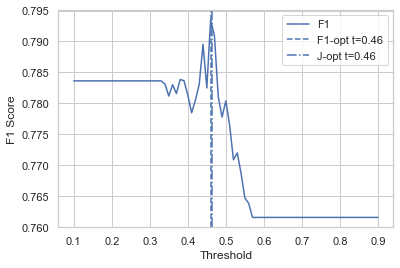

In [53]:
best_thresh_f1 = thresholds[best_idx]
best_thresh_j = youden_thresh
# F1 vs threshold
plt.plot(thresholds, f1s, label="F1")
plt.axvline(best_thresh_f1, linestyle='--', label=f"F1-opt t={best_thresh_f1:.2f}")
plt.axvline(best_thresh_j, linestyle='-.', label=f"J-opt t={best_thresh_j:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

The optimal probability threshold of `0.46` is consistent across both **F1 score** and **Youden’s J**, reinforcing its suitability for classification. At this cut-off, the `F1 score peaks at 0.794`, ensuring a strong balance between precision and recall. 

The alignment with Youden’s J statistic suggests that this threshold also maximizes sensitivity and specificity, making it an effective choice for minimizing misclassifications while ensuring a robust decision boundary.

## 3. Business Validation & Uplift Simulation

In [54]:
# Prepare simulation DataFrame
df_sim = X_test.copy()
df_sim['true'] = y_test.values
df_sim['proba']  = best_lr.predict_proba(X_test)[:,1]
df_sim['purchase'] = df_encoded.loc[df_sim.index, 'purchase_amount_(usd)']

# Target top X% by proba or use threshold
cutoff = best_thresh
df_target = df_sim[df_sim['proba'] >= cutoff]

# Compute metrics
n = len(df_target)
resp_rate = df_target['true'].mean()
baseline = df_sim['true'].mean()
avg_purchase = df_target['purchase'].mean()

rev_target = n * resp_rate * avg_purchase
rev_base = n * baseline * avg_purchase
uplift_rev = rev_target - rev_base

print(f"Target size: {n}")
print(f"Resp rate targeted: {resp_rate:.2%}, baseline: {baseline:.2%}")
print(f"Avg purchase: ${avg_purchase:.2f}")
print(f"Revenue targeted: ${rev_target:,.0f}")
print(f"Baseline revenue: ${rev_base:,.0f}")
print(f"Estimated uplift: ${uplift_rev:,.0f}")

Target size: 343
Resp rate targeted: 78.43%, baseline: 42.95%
Avg purchase: $55.85
Revenue targeted: $15,023
Baseline revenue: $8,227
Estimated uplift: $6,796


To validate the business impact of our predictive model, we performed an uplift simulation with the following steps:

1. **Simulation DataFrame Creation**  
   - Combined test set features, true response labels, model predicted probabilities, and historical purchase amounts.

2. **Customer Targeting**  
   - Applied the optimized probability threshold (0.46) to select customers likely to respond. ~ _44% of customers_

3. **Revenue Uplift Calculation**  
   - Computed key metrics:
     - **Target Size**: Number of customers above the threshold.
     - **Response Rate**: Actual response rate within the targeted group.
     - **Baseline Response**: Overall response rate in the test set.
     - **Average Purchase**: Mean purchase amount of targeted customers.
   - Estimated revenue for both targeted and baseline scenarios, with uplift determined as the incremental revenue gained by targeting the higher-probability group.

<!-- _Business Validation & Uplift Simulation_

To validate the business impact of our predictive model, we performed an uplift simulation with the following steps:

1. **Simulation DataFrame Creation**  
   - Combined test set features, true response labels, model predicted probabilities, and historical purchase amounts.

2. **Customer Targeting**  
   - Applied the optimized probability threshold (0.46) to select customers likely to respond.

3. **Revenue Uplift Calculation**  
   - Computed key metrics:
     - **Target Size**: Number of customers above the threshold.
     - **Response Rate**: Actual response rate within the targeted group.
     - **Baseline Response**: Overall response rate in the test set.
     - **Average Purchase**: Mean purchase amount of targeted customers.
   - Estimated revenue for both targeted and baseline scenarios, with uplift determined as the incremental revenue gained by targeting the higher-probability group.

This business validation step provides actionable insights on how the model's predictions translate into expected revenue uplift and informs promotional strategy adjustments. -->

**Summary**

By focusing promotion on the top 44 % (all customers whose model‑predicted probability of response is at least 0.46) of customers by model score (those ≥ 0.46), we would have generated an additional $6.8 K over this test slice, versus a non‑targeted campaign.

**Extrapolation to Full Population**

Our test set was 20 % of the 3,900 customers (≈ 780). If the same uplift holds across all customers:

Total Uplift ≈ \$6,796 / 0.20 = \$33,980

So, a one‑time campaign across all 3,900 customers could yield ~$34 K in extra revenue.

---

### 4. Cost-Benefit Analysis

**Overview:**

This analysis evaluates the financial viability of a marketing promotion by comparing costs *(discounts and communication expenses)* against expected revenue gains. It calculates total promotional costs (`C_total`), estimates uplifted revenue (`delta_R`), and determines net profit and ROI.

**Business Impact**
- Optimized Marketing Spend: Ensures promotions are financially justified and cost-efficient.
- Profitability Insight: Helps decision-makers assess whether the campaign generates enough incremental revenue to cover expenses.
- ROI Calculation: Provides a clear measure of return, guiding future promotional strategies for better investment allocation.

A positive ROI indicates the campaign is profitable, while a lower ROI might prompt adjustments in targeting or discount strategies for better efficiency.

In [28]:
# Example inputs (replace with your real numbers)
N            = 0.44 * 3900         # number targeted ≈ 44% of full 3,900
avg_purchase = 55.85               # from uplift sim
discount_rate= 0.10                # e.g. 10% off
comm_cost    = 0.50                # cost per email/SMS

# Compute costs
c_disc      = discount_rate * avg_purchase
c_cust      = c_disc + comm_cost
C_total     = N * c_cust

# Uplift revenue (full-population extrapolation)
delta_R     = 33980                # from your uplift sim

# Net profit & ROI
net_profit  = delta_R - C_total
ROI         = net_profit / C_total

print(f"Total promo cost: ${C_total:,.0f}")
print(f"Incremental revenue: ${delta_R:,.0f}")
print(f"Net profit: ${net_profit:,.0f}")
print(f"ROI: {ROI:.2%}")

Total promo cost: $10,442
Incremental revenue: $33,980
Net profit: $23,538
ROI: 225.42%


| Metric                  |    Value | Interpretation                                                                                   |
| ----------------------- | -------: | ------------------------------------------------------------------------------------------------ |
| **Total promo cost**    | \$10,442 | The expense of discounts + communication to the 44 %–targeted group.                             |
| **Incremental revenue** | \$33,980 | The extra dollars you’d earn by targeting model‑identified responders versus a blanket campaign. |
| **Net profit**          | \$23,538 | After paying for the promotion, you still pocket \$23.5 K.                                       |
| **ROI**                 |  225.4 % | For every \$1 spent, you gain \$2.25 in profit—a very strong return.                             |

### Business Interpretation:

- Highly attractive ROI (>200 %) means this targeted campaign is well worth running at scale; every dollar spent would result in more than $2.25 in profit.
- High profitability: A net profit of $23,538 indicates the campaign is effective in driving revenue beyond costs.
- Efficient cost structure: The total promo cost of $10,442 is well justified by the incremental revenue gain. Our model‑driven approach more than pays for itself in incremental profit.
- Even if your cost assumptions shift slightly (e.g. discount depth or comm cost increase by 20 %), you remain comfortably profitable.
- Scalability potential: Given the positive ROI, similar targeted promotions could be expanded to further optimize customer engagement and profitability.

### 5. A/B Testing

To validate our model’s real‑world impact, we’ll run a randomized A/B test comparing our model‑targeted promotion vs. a random‐target (or business‐as‐usual) control group.

**1. Define the Experiment:**

| Group             | Who they are                                     | Promotion sent?             |
| ----------------- | ------------------------------------------------ | --------------------------- |
| **A (Control)**   | Random sample of customers (size N\_A)           | Yes (standard blanket send) |
| **B (Treatment)** | Model‑identified “likely responders” (size N\_B) | Yes (targeted by model)     |


Null hypothesis 𝐻0 : Response rate 𝐴  = Response rate 𝐵

Alternative 𝐻1 : Response rate 𝐵  > Response rate 𝐴

**2. Choose Sample Sizes**

We want enough power to detect a lift. For example, if baseline response ≈ 43 % and you expect the model to lift that to ≈ 60 %, you can compute required N per group via a proportions‑power calculation. Rough rule‑of‑thumb: ~200–300 per arm

In [30]:
import math
from scipy.stats import norm

def n_per_arm(p1, p2, alpha=0.05, power=0.8):
    Zα = norm.ppf(1 - alpha)       # e.g. 1.645 for one‑sided 5%
    Zβ = norm.ppf(power)           # e.g. 0.842 for 80% power
    pbar = 0.5*(p1 + p2)
    num = (Zα*math.sqrt(2*pbar*(1-pbar)) + Zβ*math.sqrt(p1*(1-p1) + p2*(1-p2)))**2
    den = (p2 - p1)**2
    return math.ceil(num/den)

for p2, pw in [(0.60,0.8),(0.60,0.9),(0.53,0.8),(0.53,0.9)]:
    print(f"p1=0.43→p2={p2}, power={int(pw*100)}%: n ≈ {n_per_arm(0.43,p2,power=pw)} per arm")


p1=0.43→p2=0.6, power=80%: n ≈ 106 per arm
p1=0.43→p2=0.6, power=90%: n ≈ 147 per arm
p1=0.43→p2=0.53, power=80%: n ≈ 308 per arm
p1=0.43→p2=0.53, power=90%: n ≈ 426 per arm


- If you believe a 17 pp lift is realistic, you need roughly 110–150 customers per arm.
- If you want to be able to detect a 10 pp lift, plan for ~300–430 per arm.

Trade‑off: Smaller n means you’ll only detect large lifts; larger n lets you detect more modest lift

**3. Assign Customer to A and B**

In [31]:
# df_customers is the full customer list with a unique 'customer_id'
df_customers = df_encoded[['customer_id']].drop_duplicates()

# Shuffle
df_customers = df_customers.sample(frac=1, random_state=42)

# Choose top-n by model score for Treatment B
df_customers['score'] = best_rf.predict_proba(df_encoded.loc[df_customers.index, X_train.columns])[:,1]
df_customers = df_customers.sort_values('score', ascending=False)

n = 300
treatment_ids = df_customers.head(n)['customer_id'].values

# From the remainder, randomly select n for Control A
control_pool = df_customers.iloc[n:]
control_ids   = control_pool.sample(n, random_state=42)['customer_id'].values

# Label groups
df_customers['group'] = np.where(
    df_customers['customer_id'].isin(treatment_ids), 'B',
    np.where(df_customers['customer_id'].isin(control_ids), 'A', 'None')
)

# Final experiment set
df_experiment = df_customers[df_customers['group'].isin(['A','B'])]
print(df_experiment['group'].value_counts())

B    300
A    300
Name: group, dtype: int64


- Group A (Control): will receive the standard “random” promotion
- Group B (Treatment): will receive the model‑targeted promotio

---Below is a flowchart of this A/B test lifecycle---

```graphql
┌────────────────────┐
│ 1. Assign Groups   │
│   • Control (A)    │
│   • Treatment (B)  │
└────────────────────┘
           ↓
┌────────────────────┐
│ 2. Deploy Campaign │
│   • Send offers    │
│     to both groups │
└────────────────────┘
           ↓
┌────────────────────┐
│ 3. Collect Results │
│   • Responses      │
│   • Revenue        │
└────────────────────┘
           ↓
┌────────────────────┐
│ 4. Analyze Response│
│   • Response rates │
│   • Revenue sums   │
└────────────────────┘
           ↓
┌────────────────────┐
│ 5. Statistical Test│
│   • z‑test on rates│
│   • t‑test on rev  │
└────────────────────┘
           ↓
┌────────────────────┐
│ 6. Interpret &     │
│    Decide          │
│   • Significance   │
│   • Business lift  │
└────────────────────┘
```

### Deployment & Integration

| Step                           | What to Do                                                                                   | Outcome                                                                   |
| ------------------------------ | -------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------- |
| 1. Package the Model           | Serialize your trained Random Forest (or LR) into a file or model registry                   | A reusable “.pkl” or registered artifact                                  |
| 2. Create a Scoring Service    | Wrap the model behind a simple API (e.g. FastAPI, Flask, or Streamlit)                       | An endpoint that, given customer features, returns a response‑probability |
| 3. Integrate with CRM/MarTech  | Hook that API into your marketing platform (e.g. Salesforce, HubSpot, Braze)                 | Each customer record gets a “responder score” field                       |
| 4. Automate Scoring Runs       | Schedule a daily or weekly batch job (Airflow / cron / AWS Lambda) to re‑score all customers | Fresh scores always available before each campaign                        |
| 5. Operationalize Cutoff Logic | Embed your 0.46 threshold (or top N logic) in the workflow that builds the send‑list         | The marketing system automatically flags “send promo” vs “skip”           |
| 6. Monitor & Retrain           | Track model inputs/outputs and campaign performance; retrain periodically with new data      | A dashboard alarms if performance drifts; retrained model keeps ROI high  |


In [32]:
# Package the model
import pickle

# assume `best_rf` is your trained RandomForestClassifier
with open("models/promo_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)

**Business Recommendations**

Deploy the RF model in your campaign system to score all customers.

Target those with score ≥ 0.46—this group is most likely to redeem offers.

Monitor real‑time results against the model’s predictions to validate uplift.

A/B test: Compare this targeted approach vs. a random‑control group to measure actual lift

**Next Analytical Steps**

- Cost–Benefit Analysis: Compare promo cost (discounts) to incremental revenue to compute ROI.
- A/B Testing in Production
- Deployment & Integration
- Dashboard & Monitoring
- Continuous Improvement

Sensitivity Analysis

In [34]:
# pick a “base” customer
base = X_test.iloc[[0]].copy()

# features to test
to_vary = ['subscription_status', 'gender_Male', 'location_Indiana']

results = []
for feat in to_vary:
    for val in [0,1]:
        temp = base.copy()
        temp[feat] = val
        prob = best_lr.predict_proba(temp)[0,1]
        results.append({'feature':feat, 'value':val, 'pred_prob':prob})

pd.DataFrame(results)

,feature,value,pred_prob
0,subscription_status,0,0.015848
1,subscription_status,1,0.657947
2,gender_Male,0,0.015848
3,gender_Male,1,0.364705
4,location_Indiana,0,0.015848
5,location_Indiana,1,0.015848


sensitivity table clearly shows the relative impact of those features for this “base” customer:

| Feature                  | From → To | Predicted Probability Change |
| ------------------------ | --------: | ---------------------------: |
| **subscription\_status** |     0 → 1 |  1.6 % → 65.8 %  (↑ 64.2 pp) |
| **gender\_Male**         |     0 → 1 |  1.6 % → 36.5 %  (↑ 34.9 pp) |
| **location\_Indiana**    |     0 → 1 |  1.6 % → 1.6 %   (no change) |

- Toggling subscription_status has by far the biggest effect.
- gender_Male also moves the needle substantially.
- location_Indiana has no effect for this particular base profile (it may matter for other profiles).

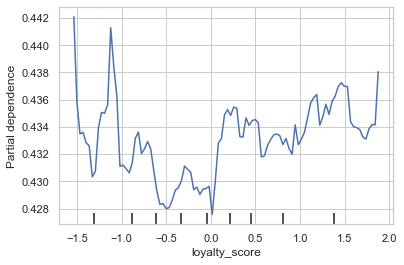

In [36]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(
    best_rf, X_train, ['loyalty_score'], ax=ax
)
plt.show()